Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

# The Linear VAE

### The model:

$
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bu}{\mathbf{u}}
\newcommand{\bI}{\mathbf{I}}
\newcommand{\bW}{\mathbf{W}}
\newcommand{\bD}{\mathbf{D}}
\newcommand{\bC}{\mathbf{C}}
\newcommand{\bS}{\mathbf{S}}
\newcommand{\bV}{\mathbf{V}}
\newcommand{\bL}{\mathbf{L}}
\newcommand{\bU}{\mathbf{U}}
\newcommand{\bR}{\mathbf{R}}
\newcommand{\bLambda}{\boldsymbol{\Lambda}}
\newcommand{\bmu}{\boldsymbol{\mu}}
\newcommand{\cN}{\mathcal{N}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\expect}{\mathbb{E}}
$
Suppose $\bz \in \reals^q$ generates $\bx \in \reals^d$. We use a standard Gaussian prior:


$$p(\bz) = \cN(\mathbf{0},\bI)$$

And define a linear generative model from the latent space with a Gaussian observation model.

$$p(\bx|\bz) = \cN( \bW \bz + \bmu, \sigma^2 \bI)$$

This model is known as [Probabilistic PCA (pPCA)](http://www.robots.ox.ac.uk/~cvrg/hilary2006/ppca.pdf). A linear VAE can be used to maximize the likelihood of pPCA.

### Optimal pPCA MLE parameters

The maximum likelihood estimate of $\bmu$ is the mean of the data. We can compute $\bW_{MLE}$ and $\sigma^2_{MLE}$ as follows:

$$\bW_{MLE} = \bU_{q}(\bLambda_q - \sigma^2 \bI)^{1/2}\bR,\\
\sigma^2_{MLE} = \frac{1}{n - q} \sum_{j=q+1}^{n}\lambda_j$$

Here $\bU_q$ corresponds to the first $q$ principal components of the data with the corresponding eigenvalues $\lambda_1, \ldots, \lambda_q$ stored in the $q\times q$ matrix $\bLambda_q$. The matrix $\bR$ is an arbitrary rotation matrix which accounts for weak identifiability in the model. The MLE for $\sigma^2$ corresponds to the average variance lost in the projection.

## Learning pPCA with a Linear VAE

We will aim to learn a variational distribution $q(\bz|\bx)$ to approximate the posterior $p(\bz|\bx)$. The variational bound is characterized as follows:

$$
\log p(\bx) = D_{KL}(q(\bz|\bx)||p(\bz|\bx)) + \expect_{q(\bz|\bx)}[−\log q(\bz|\bx) + \log p(\bx,\bz)], \\
\Rightarrow \log p(\bx)  \geq \expect_{q(\bz|\bx)}[−\log q(\bz|\bx) + \log p(\bx,\bz)], \\
= −D_{KL}(q(\bz|\bx)||p(\bz)) + \expect_{q(\bz|\bx)}[\log p(\bx|\bz)] \qquad (:= ELBO)
$$

Let us fix an amortized, linear Gaussian variational distribution:

$$q(z|x) = \cN(\bV(\bx - \bmu), \text{diag}(\sigma^2_1, \ldots, \sigma^2_q))$$

We use a diagonal covariance matrix (denoted $\bD$ later) which is shared across all data points. We show in our paper that this is sufficient to represent the true posterior distribution. Thus, the linear VAE corresponds exactly to fitting a pPCA model with variational inference.

### Exact ELBO computation 

The ELBO is made up of two components, the prior KL divergence (i), $KL(q(\bz|\bx)||p(\bz))$ and the reconstruction loss (ii), $\expect_{q(\bz|\bx)}[\log p(\bx|\bz)]$.

Because everything is Gaussian, we can compute these terms in closed-form.

(i): $KL(q(\bz|\bx)||p(\bz)) = 0.5(tr(\bD) -\log\det(\bD) + (\bx-\bmu)\bV^T\bV(\bx - \bmu) - q)$

(ii): $\expect_{q(\bz|\bx)}\left[ \log p(\bx|\bz) \right] = \frac{1}{2\sigma^2} [ -tr(\bW\bD\bW^T) - (\bx - \bmu)^T\bV^T\bW^T\bW\bV(\bx-\bmu) + 2(\bx - \bmu)^T\bW\bV(\bx-\bmu) - (\bx - \bmu)^T(\bx - \bmu)] - \frac{d}{2}\log 2\pi\sigma^2$

Thus, we can train the linear VAE using exact gradients to validate the theoretical results presented in our paper.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.data import Dataset
import tensorflow_datasets as tfds

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

_LOG_2PI = np.log(2 * np.pi)

## Data loading utilities

In [0]:
def load_mnist_data(take):
  '''Load a subset of the MNIST dataset, repeated.

  Args:
    take: The amount of training data to take.
  
  Returns:
    A shuffled subset of the MNIST training dataset.
  '''
  mnist_builder = tfds.builder("mnist")
  mnist_info = mnist_builder.info
  mnist_builder.download_and_prepare()
  datasets = mnist_builder.as_dataset()
  train_dataset = datasets['train']
  train_dataset = train_dataset.take(take).map(
      lambda x : tf.reshape(tf.cast(x['image'], tf.float32) / 255.0, [-1]))
  return train_dataset


## Linear VAE

In [0]:
class LinearVAEConfig(object):
  """Config class for the Linear VAE.

  Args:
    input_dim: Number of input dimensions (default: 784)
    hidden_dim: Number of hidden dimensions (default: 20)
    trainable_sigma: Whether observation noise should be learned (default: True)
    sigma_init: Initial value of sigma^2 (default: None)
    stochastic_ELBO: Use stochastic ELBO estimation (default: False)
  """

  def __init__(self,
               input_dim=784,
               hidden_dim=20,
               trainable_sigma=True,
               sigma_init=None,
               stochastic_ELBO=False):
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.trainable_sigma = trainable_sigma
    self.sigma_init = sigma_init
    self.stochastic_ELBO = stochastic_ELBO

class LinearVAE(object):
  """Linear VAE
  
  Allows for the reconstruction error to be computed analytically or via
  single-sample stochastic estimation.
  """

  def __init__(self, input_tensor, config=LinearVAEConfig()):
    self._config = config
    self.input_tensor = input_tensor

    self.z_logvar = tf.get_variable(
        'logvars', shape=(config.hidden_dim), trainable=True)
    self.expanded_z_logvar = tf.expand_dims(self.z_logvar, 0)

    self.enc_weight = tf.get_variable(
        'enc_weight',
        shape=(config.input_dim, config.hidden_dim),
        trainable=True)
    self.mean = tf.get_variable(
        'mean', shape=(config.input_dim), trainable=True)
    self.dec_weight = tf.get_variable(
        'dec_weight',
        shape=(config.hidden_dim, config.input_dim),
        trainable=True)
    if self._config.sigma_init is not None:
      sigma_init = tf.constant_initializer(np.log(self._config.sigma_init))
    else:
      sigma_init = None
    self.log_sigma_sq = tf.get_variable(
        'log_sigma',
        shape=(),
        initializer=sigma_init,
        trainable=self._config.trainable_sigma)
    self.sigma_sq = tf.exp(self.log_sigma_sq)

    self.z_mean = tf.matmul(self.input_tensor - self.mean, self.enc_weight)
    if self._config.stochastic_ELBO:
      eps = tf.random_normal(
        (tf.shape(self.input_tensor)[0], self._config.hidden_dim),
        mean=0.0,
        stddev=1.0,
        dtype=tf.float32)
      self.z_sample = self.z_mean + eps * tf.exp(0.5 * self.expanded_z_logvar)

      with tf.variable_scope('decoder') as dec_scope:
        self.reconstruction = tf.matmul(self.z_sample, self.dec_weight)

    ## Loss
    with tf.name_scope('losses'):
      # Reconstruction loss under recognition model
      if self._config.stochastic_ELBO:
        self.recon_loss = self.stochastic_recon(self.input_tensor,
                                                self.reconstruction)
      else:
        self.recon_loss = self.analytic_recon(self.input_tensor)

      # KL Divergence to Gaussian prior in latent space
      # We assume prior mean of 0.0 and standard deviation of 1.0
      kl = self.gaussian_kl_divergence(self.z_mean, self.expanded_z_logvar,
                                       0.0,
                                       2 * tf.log(1.0))
      avg_kl = tf.reduce_mean(kl, 0)
      self.kl_div = tf.reduce_sum(avg_kl)
      self.elbo = self.recon_loss + self.kl_div

  def analytic_recon(self, x):
    """Compute the analytic reconstruction error for a linear VAE.

    Args:
      x: The input tensor.

    Returns:

      E_q[log p(x|z)]
    """
    wv = tf.matmul(self.enc_weight, self.dec_weight)
    x_sub_mu = x - self.mean

    wvx = tf.matmul(x_sub_mu, wv)
    xvwwvx = tf.reduce_sum(wvx * wvx, 1)

    tr_wdw = tf.trace(
        tf.matmul(
            self.dec_weight,
            tf.expand_dims(tf.exp(self.z_logvar), 1) * self.dec_weight,
            transpose_a=True))

    xwvx = tf.reduce_sum(wvx * x_sub_mu, 1)

    xx = tf.reduce_sum(x_sub_mu * x_sub_mu, 1)

    d = self._config.input_dim
    recon_loss = 0.5 * (
        (tr_wdw + xvwwvx - 2.0 * xwvx + xx) / self.sigma_sq + d *
        (_LOG_2PI + self.log_sigma_sq))
    return tf.reduce_mean(recon_loss)
  
  def stochastic_recon(self, x, logits):
    """Stochastic estimation of the reconstruction error.

    Computes the reconstruction error under a Gaussian observation model.

    Args:
      x: The input tensor.
      logits: The stochastic output of the decoder.

    Returns:

      MEAN_i(log p(x_i|z_i))
    """
    input_dim = tf.cast(tf.shape(x)[1], tf.float32)
    batch_size = tf.shape(x)[0]
    inputs = tf.reshape(x, (batch_size, -1))
    logits = tf.reshape(logits, (batch_size, -1))

    return tf.reduce_mean(0.5 * (tf.reduce_sum(
        (inputs - logits)**2 / self.sigma_sq, 1) +
                                  (_LOG_2PI + self.log_sigma_sq) * input_dim))

  def gaussian_kl_divergence(self, q_mean, q_logvar, p_mean, p_logvar):
    """KL Divergence between two Gaussian distributions.

    Given q ~ N(mu_1, sigma^2_1) and p ~ N(mu_2, sigma^2_2), this function
    returns,

    KL(q||p) = log (sigma^2_2 / sigma^2_1) +
      (sigma^2_1 + (mu_1 - mu_2)^2) / (2 sigma^2_2) - 0.5

    Args:
      q_mean: Mean of proposal distribution.
      q_logvar: Log-variance of proposal distribution
      p_mean: Mean of prior distribution.
      p_logvar: Log-variance of prior distribution

    Returns:
      The KL divergence between q and p ( KL(q||p) ).
    """
    return 0.5 * (
        p_logvar - q_logvar + (tf.exp(q_logvar) +
                               (q_mean - p_mean)**2) / tf.exp(p_logvar) - 1)

## Probabilistic PCA

In [0]:
def compute_ppca_mle(covariance, z_dim):
  """Compute the probabilistic pPCA MLE.

  Args:
    covariance: The data covariance matrix
    z_dim: The number of hidden dimensions
  
  Returns:
    (sigma_sq_mle, W_mle): The MLE solution to pPCA.
  """
  w, u = np.linalg.eigh(covariance)
  eigvals, eigvecs = w[::-1], u[:,::-1]
  missing_eigvals = eigvals[z_dim:]
  sigma_sq_mle = missing_eigvals.sum() / (eigvals.shape[0] - z_dim)
  
  active_eigvals = np.diag(eigvals[:z_dim])
  active_components = eigvecs[:,:z_dim]
  
  W_mle = active_components.dot(
      (active_eigvals - sigma_sq_mle * np.eye(z_dim)) ** 0.5)
  return sigma_sq_mle, W_mle

def log_p_x_true(W, sigma_sq, N, data_cov):
  """Compute the model likelihood of pPCA.

  Args:
    W: The decoder weight.
    sigma_sq: Sigma^2 of observation model
    N: Total number of data points
    data_cov: The dxd data covariance matrix
  """
  d = data_cov.shape[0]
  C = W.dot(W.T) + sigma_sq * np.eye(W.shape[0])
  loglik = d * _LOG_2PI + np.linalg.slogdet(C)[1]
  loglik += np.trace(np.linalg.inv(C).dot(data_cov))
  return -loglik * N / 2

# Training the Linear VAE and pPCA

## Probabilistic PCA

In [0]:
# Some hyperparameters
DATA_SIZE = 1000
Z_DIM = 200
VAE_STEPS = 10000

In [0]:
mnist_data = np.array(list(tfds.as_numpy(load_mnist_data(DATA_SIZE))))
covariance = np.cov(mnist_data, rowvar=False)

sigma_mle, W_mle = compute_ppca_mle(covariance, Z_DIM)
avg_log_p_mle = log_p_x_true(W_mle, sigma_mle, DATA_SIZE, covariance)/DATA_SIZE
print("Avg. Maximum Likelihood: {}".format(avg_log_p_mle))

Avg. Maximum Likelihood: 941.6543285914813


## Linear VAE

In [0]:
def build_train_op(mnist_data, learning_rate=0.001):
  """Builds and returns a training op for optimizing the linear VAE

  Resets the default graph and builds a new VAE and optimizer train op.

  Args:
    learning_rate: Learning rate for the Adam optimizer (default 0.01)
  
  Returns:
    (vae, train_op)
  """
  tf.reset_default_graph()

  input_data = tf.data.Dataset.from_tensor_slices(mnist_data)
  input_data = input_data.repeat().batch(DATA_SIZE)
  input_tensor = input_data.make_one_shot_iterator().get_next()

  # Build linear VAE
  vae_config = LinearVAEConfig(hidden_dim=Z_DIM, sigma_init=1.0)
  vae = LinearVAE(input_tensor, vae_config)

  # Make optimizer train op
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  return vae, optimizer.minimize(vae.elbo)

In [0]:
# Use the same data as pPCA
vae, train_op = build_train_op(mnist_data, 0.001)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
elbos = []
# Note that floating point errors in the analytic ELBO computation
# lead to values which may (slightly) exceed the true log likelihood here
for i in range(12000):
  elbo = -sess.run([train_op, vae.elbo])[-1]
  if i % 200 == 0:
    elbos.append(elbo)
    print("ELBO at step {} = {}".format(i, elbo))

ELBO at step 0 = -968.6621704101562
ELBO at step 200 = -668.5194702148438
ELBO at step 400 = -590.5942993164062
ELBO at step 600 = -514.5360107421875
ELBO at step 800 = -441.3041076660156
ELBO at step 1000 = -369.9105529785156
ELBO at step 1200 = -299.8696594238281
ELBO at step 1400 = -231.04783630371094
ELBO at step 1600 = -163.48062133789062
ELBO at step 1800 = -97.22725677490234
ELBO at step 2000 = -32.38248062133789
ELBO at step 2200 = 31.040729522705078
ELBO at step 2400 = 92.99249267578125
ELBO at step 2600 = 153.3643341064453
ELBO at step 2800 = 212.14169311523438
ELBO at step 3000 = 269.2225341796875
ELBO at step 3200 = 324.53912353515625
ELBO at step 3400 = 377.9089050292969
ELBO at step 3600 = 429.6019287109375
ELBO at step 3800 = 479.26446533203125
ELBO at step 4000 = 526.95068359375
ELBO at step 4200 = 572.6626586914062
ELBO at step 4400 = 616.456787109375
ELBO at step 4600 = 658.244384765625
ELBO at step 4800 = 698.238525390625
ELBO at step 5000 = 736.5476684570312
ELBO at

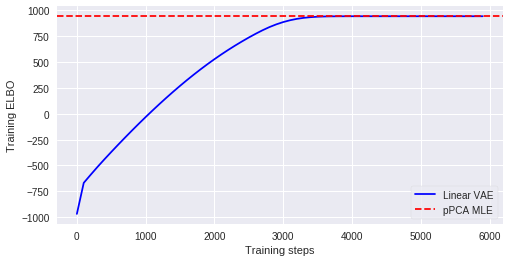

In [0]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(100*np.arange(len(elbos)), elbos, color='blue', label='Linear VAE')
ax.axhline(avg_log_p_mle, ls='--', color='red', label='pPCA MLE')
ax.set_xlabel('Training steps')
ax.set_ylabel('Training ELBO')
plt.legend(frameon=True)

In [0]:
W_vae, log_sigma_sq = sess.run([vae.dec_weight, vae.log_sigma_sq])
W_vae = W_vae.T
sigma_sq_vae = np.exp(log_sigma_sq)

Avg. VAE Likelihood: 941.6113943606014
Avg. Maximum Likelihood: 941.6543285914813


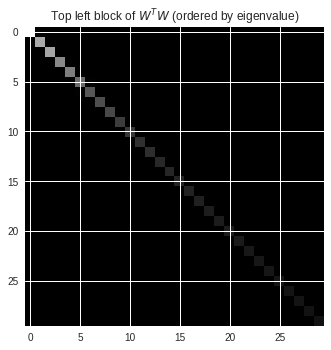

In [0]:
avg_log_p_vae = log_p_x_true(W_vae, sigma_sq_vae, DATA_SIZE, covariance)/DATA_SIZE

# Reordering rows/columns by eigenvalues for visualization
diag = np.diag(W_vae.T.dot(W_vae))
sort_idx = np.argsort(-diag)
P = np.zeros((W_vae.shape[1], W_vae.shape[1]))
for i,j in enumerate(sort_idx):
  P[i][j] = 1
ordered_WTW = P.dot(W_vae.T.dot(W_vae)).dot(P.T)

plt.figure()
plt.imshow(ordered_WTW[:30,:30], cmap='gray', vmin=0.0)
plt.title(r'Top left block of $W^T W$ (ordered by eigenvalue)')
print("Avg. VAE Likelihood: {}".format(avg_log_p_vae))
print("Avg. Maximum Likelihood: {}".format(avg_log_p_mle))